In [1]:
import os
import re
import math
import pickle
import random
import Orange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from humanize import ordinal
from scikit_posthocs import posthoc_nemenyi
from scipy.stats import mannwhitneyu
from scipy.spatial import ConvexHull
from skcriteria import Data, MAX
from skcriteria.madm.closeness import TOPSIS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
DATA_PATH = Path('data')
RESULTS_PATH = DATA_PATH / 'results'
META_FEATURES_PATH = DATA_PATH / 'meta_features'
OUTPUT_PATH = Path('output', 'wrn')

In [3]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
results_dfs = {}
for filename in os.listdir(RESULTS_PATH):
    archtecture = re.search(r'(?<=results_).*(?=.csv)', filename).group()
    results_dfs[archtecture] = pd.read_csv(RESULTS_PATH / filename)

In [5]:
results_df = pd.concat(results_dfs.values(), ignore_index=True)

In [6]:
results_df.head()

,Architecture,Task,Accuracy_vector,Precision_vector,Recall_vector,F1_vector,Accuracy_avg,Precision_avg,Recall_avg,F1_avg
0,ResNet10,airplane-automobile,"[0.942, 0.939, 0.93, 0.9275, 0.916, 0.9315, 0....","[0.9203510204081633, 0.9051657032755298, 0.893...","[0.932, 0.958, 0.948, 0.939, 0.954, 0.938, 0.8...","[0.9414141414141414, 0.9401373895976447, 0.931...",0.92505,0.892683,0.9274,0.925149
1,ResNet10,airplane-bird,"[0.89, 0.889, 0.8935, 0.882, 0.875, 0.8895, 0....","[0.8614113785557986, 0.8492249488752557, 0.852...","[0.847, 0.878, 0.89, 0.886, 0.888, 0.89, 0.887...","[0.8850574712643677, 0.8877654196157735, 0.893...",0.88480,0.843588,0.8753,0.883662
2,ResNet10,airplane-cat,"[0.9245, 0.9325, 0.935, 0.926, 0.932, 0.925, 0...","[0.8897871921182265, 0.8980344995140912, 0.905...","[0.932, 0.947, 0.937, 0.938, 0.961, 0.909, 0.8...","[0.9250620347394541, 0.933464760965993, 0.9351...",0.92580,0.893557,0.9279,0.925876
3,ResNet10,airplane-deer,"[0.9475, 0.9125, 0.943, 0.93, 0.917, 0.936, 0....","[0.9234072781655036, 0.8553790534618757, 0.921...","[0.949, 0.983, 0.933, 0.98, 0.935, 0.928, 0.95...","[0.947578632051922, 0.9182624941616068, 0.9424...",0.93320,0.900529,0.9460,0.934192
4,ResNet10,airplane-dog,"[0.948, 0.9515, 0.936, 0.947, 0.9345, 0.9475, ...","[0.924704, 0.9361238390092881, 0.9224043010752...","[0.948, 0.936, 0.901, 0.95, 0.914, 0.93, 0.955...","[0.948, 0.9507364144235654, 0.9336787564766839...",0.94470,0.923633,0.9363,0.944177


In [7]:
TASKS = results_df['Task'].unique()
ARCHITECTURES = results_df['Architecture'].unique()

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(ARCHITECTURES)

LabelEncoder()

In [9]:
leave_one_out = LeaveOneOut()

In [10]:
metrics_avg = {}
metrics_vectors = {}
for task in TASKS:
    df = results_df.query(f'Task == "{task}"')
    metrics_avg[task] = {}
    metrics_vectors[task] = {}
    for _, row in df.iterrows():
        metrics_avg[task][row['Architecture']] = {
            'accuracy': row['Accuracy_avg'],
            'precision': row['Precision_avg'],
            'recall': row['Recall_avg'],
            'f1': row['F1_avg']
        }
        metrics_vectors[task][row['Architecture']] = {
            'accuracy': np.array(eval(row['Accuracy_vector'])),
            'precision': np.array(eval(row['Precision_vector'])),
            'recall': np.array(eval(row['Recall_vector'])),
            'f1': np.array(eval(row['F1_vector']))
        }

In [11]:
ranking_architectures = {}
for task in TASKS:
    metrics_columns = ['Accuracy_avg', 'Precision_avg', 'Recall_avg', 'F1_avg']
    metrics_df = results_df.query(f'Task == "{task}"')[metrics_columns]
    data = Data(metrics_df.to_numpy(), criteria=[MAX, MAX, MAX, MAX])
    topsis = TOPSIS()
    ranking_architectures[task] = results_df.iloc[
        metrics_df.index[np.argsort(topsis.decide(data).rank_)]
    ]['Architecture'].tolist()

In [12]:
best_architectures = [
    ranking_architectures[task][0]
    for task in TASKS
]

In [13]:
y = label_encoder.transform(best_architectures)

In [14]:
def load_meta_features(feature_extractor_name: str) -> np.ndarray:
    meta_features = []
    for task in TASKS:
        filename = task + '.pkl'
        with open(META_FEATURES_PATH / feature_extractor_name / filename, 'rb') as f:
            meta_features.append(pickle.load(f))
    return np.array(meta_features)

In [15]:
handcraft_X = load_meta_features('handcraft')

In [16]:
wrn_X = load_meta_features('wrn')

In [17]:
def make_dataset_map_plot(X, y):

    def encircle(i, j, ax=None, **kw):
        if not ax:
            ax = plt.gca()
        p = np.c_[i, j]
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices, :], **kw)
        ax.add_patch(poly)

    lda = LinearDiscriminantAnalysis(n_components=2)

    component_x, component_y = lda.fit_transform(X, y).T

    g = sns.scatterplot(component_x, component_y, hue=y, style=y)
    g.legend(fontsize='x-small', frameon=False)

    for label, color in zip(np.unique(y), ('r', 'g', 'y', 'b')):
        index = np.where(label == pd.Series(y))
        encircle(
            component_x[index],
            component_y[index],
            ec=color,
            fc=color,
            alpha=0.15
        )

    plt.savefig(OUTPUT_PATH / 'datasets_map.png', dpi=1200, bbox_inches='tight')
    plt.show()

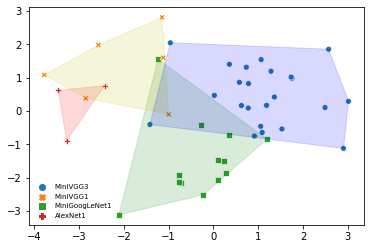

In [18]:
make_dataset_map_plot(wrn_X, best_architectures)

In [19]:
%%time

gt_recommendations = dict(zip(TASKS, best_architectures))

CPU times: user 18 µs, sys: 1e+03 ns, total: 19 µs
Wall time: 23.6 µs


In [20]:
%%time

handcraft_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_rf_recommendations[task] = recommended_architecture

CPU times: user 7.62 s, sys: 20.2 ms, total: 7.64 s
Wall time: 7.67 s


In [21]:
%%time

wrn_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(wrn_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(wrn_X[test_index])
    )[0]
    wrn_rf_recommendations[task] = recommended_architecture

CPU times: user 8.4 s, sys: 32 ms, total: 8.43 s
Wall time: 8.43 s


In [22]:
%%time

handcraft_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_knn_recommendations[task] = recommended_architecture

CPU times: user 67.8 ms, sys: 0 ns, total: 67.8 ms
Wall time: 88.4 ms


In [23]:
%%time

wrn_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(wrn_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(wrn_X[test_index])
    )[0]
    wrn_knn_recommendations[task] = recommended_architecture

CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 104 ms


In [24]:
%%time

oner_recommendations = []
for _ in range(10):
    recommended_architecture = random.choice(ARCHITECTURES)
    oner_recommendations.append({
        task: recommended_architecture
        for task in TASKS
    })

CPU times: user 150 µs, sys: 0 ns, total: 150 µs
Wall time: 155 µs


In [25]:
%%time

random_recommendations = []
for _ in range(10):
    random_recommendations.append({
        task: random.choice(ARCHITECTURES)
        for task in TASKS
    })

CPU times: user 594 µs, sys: 0 ns, total: 594 µs
Wall time: 598 µs


In [26]:
def make_results(recommendations):
    results = {}
    for task in TASKS:
        best_architecture = ranking_architectures[task][0]
        worst_architecture = ranking_architectures[task][-1]
        recommended_architecture = recommendations[task]
        results[task] = {
            'Ranking_architectures': ', '.join(ranking_architectures[task]),
            'Recommendation_rank': ordinal(ranking_architectures[task].index(recommended_architecture) + 1),
            'P_value[best]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][best_architecture]['accuracy']
            )[1],
            'P_value[worst]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][worst_architecture]['accuracy']
            )[1],
            'Architecture[recommended]': recommended_architecture,
            'Architecture[best]': best_architecture,
            'Architecture[worst]': worst_architecture,
            'Accuracy_avg[recommended]': metrics_avg[task][recommended_architecture]['accuracy'],
            'Accuracy_avg[best]': metrics_avg[task][best_architecture]['accuracy'],
            'Accuracy_avg[worst]': metrics_avg[task][worst_architecture]['accuracy'],
            'Precision_avg[recommended]': metrics_avg[task][recommended_architecture]['precision'],
            'Precision_avg[best]': metrics_avg[task][best_architecture]['precision'],
            'Precision_avg[worst]': metrics_avg[task][worst_architecture]['precision'],
            'Recall_avg[recommended]': metrics_avg[task][recommended_architecture]['recall'],
            'Recall_avg[best]': metrics_avg[task][best_architecture]['recall'],
            'Recall_avg[worst]': metrics_avg[task][worst_architecture]['recall'],
            'F1_avg[recommended]': metrics_avg[task][recommended_architecture]['f1'],
            'F1_avg[best]': metrics_avg[task][best_architecture]['f1'],
            'F1_avg[worst]': metrics_avg[task][worst_architecture]['f1']
        }
    return results

In [27]:
gt_results = make_results(gt_recommendations)
handcraft_rf_results = make_results(handcraft_rf_recommendations)
handcraft_knn_results = make_results(handcraft_knn_recommendations)
wrn_rf_results = make_results(wrn_rf_recommendations)
wrn_knn_results = make_results(wrn_knn_recommendations)

In [28]:
gt_results_df = pd.DataFrame(gt_results).T.rename_axis('Task').reset_index()
handcraft_rf_results_df = pd.DataFrame(handcraft_rf_results).T.rename_axis('Task').reset_index()
handcraft_knn_results_df = pd.DataFrame(handcraft_knn_results).T.rename_axis('Task').reset_index()
wrn_rf_results_df = pd.DataFrame(wrn_rf_results).T.rename_axis('Task').reset_index()
wrn_knn_results_df = pd.DataFrame(wrn_knn_results).T.rename_axis('Task').reset_index()

In [29]:
oner_results_10_executions = [
    make_results(recommendations)
    for recommendations in oner_recommendations
]

In [30]:
random_results_10_executions = [
    make_results(recommendations)
    for recommendations in random_recommendations
]

In [31]:
oner_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in oner_results_10_executions
], ignore_index=True)

In [32]:
random_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in random_results_10_executions
], ignore_index=True)

In [33]:
gt_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",1st,0.484868,9.13359e-05,MiniVGG1,MiniVGG1,ResNet10,0.91925,0.91925,0.8848,0.878482,0.878482,0.843588,0.9418,0.9418,0.8753,0.921148,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [34]:
gt_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    45
Name: Task, dtype: int64

In [35]:
gt_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [36]:
gt_results_df.groupby('Architecture[best]').Task.count()

Architecture[best]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [37]:
gt_results_df.groupby('Architecture[worst]').Task.count()

Architecture[worst]
AlexNet1            1
MiniVGG1            4
ResNet10            6
SmallSqueezeNet    34
Name: Task, dtype: int64

In [38]:
handcraft_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [39]:
handcraft_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    19
2nd    15
3rd     8
4th     2
6th     1
Name: Task, dtype: int64

In [40]:
handcraft_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           1
MiniGoogLeNet1    12
MiniVGG1           2
MiniVGG3          30
Name: Task, dtype: int64

In [41]:
wrn_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [42]:
wrn_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    19
2nd    17
3rd     7
4th     1
6th     1
Name: Task, dtype: int64

In [43]:
wrn_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
MiniGoogLeNet1     9
MiniVGG1           2
MiniVGG3          34
Name: Task, dtype: int64

In [44]:
handcraft_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0651403,0.0186382,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9396,0.94775,0.8408,0.919533,0.915364,0.816722,0.927,0.9735,0.94,0.938489,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [45]:
handcraft_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    16
2nd    17
3rd     7
4th     5
Name: Task, dtype: int64

In [46]:
handcraft_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           1
MiniGoogLeNet1    15
MiniVGG1           1
MiniVGG3          28
Name: Task, dtype: int64

In [47]:
wrn_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",2nd,0.00158711,0.000746358,AlexNet1,MiniVGG3,SmallSqueezeNet,0.91875,0.9357,0.70285,0.878782,0.904545,0.667966,0.9384,0.9446,0.6881,0.920444,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [48]:
wrn_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    17
2nd    13
3rd     9
4th     6
Name: Task, dtype: int64

In [49]:
wrn_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           1
MiniGoogLeNet1    16
MiniVGG1           2
MiniVGG3          26
Name: Task, dtype: int64

In [50]:
oner_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",4th,0.000842869,0.410132,SmallSqueezeNet,MiniGoogLeNet1,AlexNet1,0.97125,0.9813,0.97055,0.957307,0.974671,0.96372,0.9728,0.9763,0.9552,0.971265,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",6th,0.000842869,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.93615,0.9801,0.93615,0.921241,0.976707,0.921241,0.914,0.9671,0.914,0.934866,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",6th,0.000285888,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.92565,0.97825,0.92565,0.896233,0.970667,0.896233,0.9546,0.9724,0.9546,0.930716,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",6th,0.000740226,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.88885,0.97565,0.88885,0.866129,0.963455,0.866129,0.9128,0.978,0.9128,0.897996,0.975767,0.897996


In [51]:
oner_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st     68
2nd     77
3rd     84
4th     49
5th     61
6th    111
Name: Task, dtype: int64

In [52]:
oner_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st     6.8
2nd     7.7
3rd     8.4
4th     4.9
5th     6.1
6th    11.1
Name: Task, dtype: float64

In [53]:
oner_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           135
MiniGoogLeNet1      45
MiniVGG3            90
ResNet10            45
SmallSqueezeNet    135
Name: Task, dtype: int64

In [54]:
oner_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
AlexNet1           13.5
MiniGoogLeNet1      4.5
MiniVGG3            9.0
ResNet10            4.5
SmallSqueezeNet    13.5
Name: Task, dtype: float64

In [55]:
random_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",2nd,0.484914,0.000121743,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9719,0.97175,0.87925,0.956602,0.953785,0.85842,0.9766,0.9827,0.808,0.972037,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",4th,0.0319611,9.08256e-05,AlexNet1,MiniVGG1,ResNet10,0.91105,0.91925,0.8848,0.87307,0.878482,0.843588,0.9188,0.9418,0.8753,0.911862,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",6th,0.00109688,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.9046,0.95015,0.9046,0.872486,0.920075,0.872486,0.8927,0.9716,0.8927,0.900057,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",6th,0.000641022,0.484681,ResNet10,MiniVGG3,ResNet10,0.9447,0.963,0.9447,0.923633,0.945098,0.923633,0.9363,0.9663,0.9363,0.944177,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",1st,0.484776,0.00138271,MiniGoogLeNet1,MiniGoogLeNet1,AlexNet1,0.9813,0.9813,0.97055,0.974671,0.974671,0.96372,0.9763,0.9763,0.9552,0.981136,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000842869,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9801,0.9801,0.93615,0.976707,0.976707,0.921241,0.9671,0.9671,0.914,0.979792,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",4th,0.22459,0.00109688,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96425,0.97825,0.92565,0.947815,0.970667,0.896233,0.9823,0.9724,0.9546,0.967171,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",6th,0.000740226,0.484868,SmallSqueezeNet,MiniVGG3,SmallSqueezeNet,0.88885,0.97565,0.88885,0.866129,0.963455,0.866129,0.9128,0.978,0.9128,0.897996,0.975767,0.897996


In [56]:
random_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    78
2nd    66
3rd    70
4th    76
5th    71
6th    89
Name: Task, dtype: int64

In [57]:
random_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st    7.8
2nd    6.6
3rd    7.0
4th    7.6
5th    7.1
6th    8.9
Name: Task, dtype: float64

In [58]:
random_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           63
MiniGoogLeNet1     74
MiniVGG1           80
MiniVGG3           66
ResNet10           76
SmallSqueezeNet    91
Name: Task, dtype: int64

In [59]:
random_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
AlexNet1           6.3
MiniGoogLeNet1     7.4
MiniVGG1           8.0
MiniVGG3           6.6
ResNet10           7.6
SmallSqueezeNet    9.1
Name: Task, dtype: float64

In [60]:
algorithms_recommendations_dfs = {
    'GT': gt_results_df,
    'handcraft_RF': handcraft_rf_results_df,
    'wrn_RF': wrn_rf_results_df,
    'handcraft_KNN': handcraft_knn_results_df,
    'wrn_KNN': wrn_knn_results_df,
    'OneR': oner_results_df,
    'Random': random_results_df
}

In [61]:
metrics_dfs = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    metrics_dfs[algorithm] = recommendations_df.groupby('Task').apply(np.mean).reset_index()

In [62]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_mean': np.mean(metrics_df['Accuracy_avg[recommended]']),
        'Accuracy_std': np.std(metrics_df['Accuracy_avg[recommended]']),
        'Precision_mean': np.mean(metrics_df['Precision_avg[recommended]']),
        'Precision_std': np.std(metrics_df['Precision_avg[recommended]']),
        'Recall_mean': np.mean(metrics_df['Recall_avg[recommended]']),
        'Recall_std': np.std(metrics_df['Recall_avg[recommended]']),
        'F1_mean': np.mean(metrics_df['F1_avg[recommended]']),
        'F1_std': np.std(metrics_df['F1_avg[recommended]'])
    }
pd.DataFrame(data).T

,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std
GT,0.946940,0.037275,0.923003,0.051634,0.954076,0.038517,0.947482,0.037054
handcraft_RF,0.940093,0.042497,0.915967,0.053092,0.941191,0.064242,0.939210,0.046779
wrn_RF,0.940091,0.043788,0.916328,0.054297,0.940711,0.065957,0.939222,0.048055
handcraft_KNN,0.941791,0.036199,0.917814,0.048808,0.944056,0.042035,0.941651,0.036437
wrn_KNN,0.939147,0.043724,0.915039,0.055414,0.939980,0.057142,0.938426,0.046521
OneR,0.913520,0.054938,0.886286,0.066388,0.915433,0.053065,0.911140,0.055969
Random,0.914298,0.060514,0.887106,0.071699,0.918104,0.057550,0.912915,0.060027


In [63]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(10 if algorithm in {'Random', 'OneR'} else 1)
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,wrn_RF,handcraft_KNN,wrn_KNN,OneR,Random
1st,45.0,19.0,19.0,16.0,17.0,6.8,7.8
2nd,0.0,15.0,17.0,17.0,13.0,7.7,6.6
3rd,0.0,8.0,7.0,7.0,9.0,8.4,7.0
4th,0.0,2.0,1.0,5.0,6.0,4.9,7.6
5th,0.0,0.0,0.0,0.0,0.0,6.1,7.1
6th,0.0,1.0,1.0,0.0,0.0,11.1,8.9


In [64]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(len(recommendations_df))
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,wrn_RF,handcraft_KNN,wrn_KNN,OneR,Random
1st,1.0,0.422222,0.422222,0.355556,0.377778,0.151111,0.173333
2nd,0.0,0.333333,0.377778,0.377778,0.288889,0.171111,0.146667
3rd,0.0,0.177778,0.155556,0.155556,0.200000,0.186667,0.155556
4th,0.0,0.044444,0.022222,0.111111,0.133333,0.108889,0.168889
5th,0.0,0.000000,0.000000,0.000000,0.000000,0.135556,0.157778
6th,0.0,0.022222,0.022222,0.000000,0.000000,0.246667,0.197778


In [65]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_p_value': mannwhitneyu(
            metrics_df['Accuracy_avg[recommended]'],
            metrics_df['Accuracy_avg[best]']
        )[1],
        'Precision_p_value': mannwhitneyu(
            metrics_df['Precision_avg[recommended]'],
            metrics_df['Precision_avg[best]']
        )[1],
        'Recall_p_value': mannwhitneyu(
            metrics_df['Recall_avg[recommended]'],
            metrics_df['Recall_avg[best]']
        )[1],
        'F1_p_value': mannwhitneyu(
            metrics_df['F1_avg[recommended]'],
            metrics_df['F1_avg[best]']
        )[1]
    }
pd.DataFrame(data)

,GT,handcraft_RF,wrn_RF,handcraft_KNN,wrn_KNN,OneR,Random
Accuracy_p_value,0.49839,0.139752,0.180894,0.113811,0.125068,0.000160,0.000541
Precision_p_value,0.49839,0.184102,0.230125,0.180901,0.186260,0.000871,0.001884
Recall_p_value,0.49839,0.232582,0.318421,0.083790,0.147057,0.000008,0.000103
F1_p_value,0.49839,0.133571,0.186258,0.098311,0.112264,0.000128,0.000293


In [66]:
def make_cd(metric):
    algorithms = list(metrics_dfs.keys())
    data = [
        metrics_dfs[algorithm][metric].tolist()
        for algorithm in algorithms
    ]
    result_df = posthoc_nemenyi(data)
    result_df.index, result_df.columns = algorithms, algorithms
    names = algorithms
    avranks = (1 - np.abs(result_df['GT'])) * 5 + 1
    cd = Orange.evaluation.compute_CD(avranks, 45)
    print('cd:', cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd)
    plt.savefig(OUTPUT_PATH / f'cd_{metric}.png', dpi=1200, bbox_inches='tight')
    plt.show()

cd: 1.3427239947686223


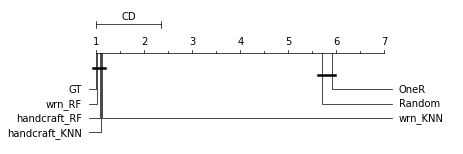

In [67]:
make_cd('Accuracy_avg[recommended]')

cd: 1.3427239947686223


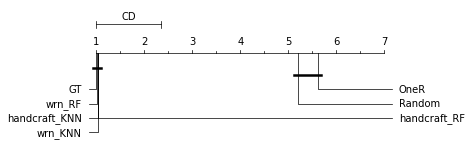

In [68]:
make_cd('Precision_avg[recommended]')

cd: 1.3427239947686223


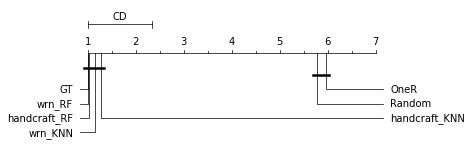

In [69]:
make_cd('Recall_avg[recommended]')

cd: 1.3427239947686223


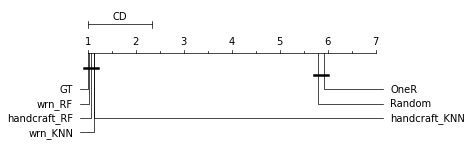

In [70]:
make_cd('F1_avg[recommended]')

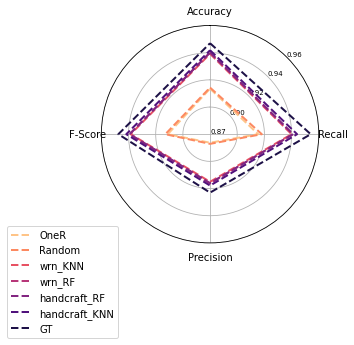

In [71]:
data = {
    'Algorithm': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F-Score': []
}

for algorithm, metrics_df in metrics_dfs.items():
    data['Algorithm'].append(algorithm)
    data['Recall'].append(np.mean(metrics_df['Recall_avg[recommended]']))
    data['Accuracy'].append(np.mean(metrics_df['Accuracy_avg[recommended]']))
    data['F-Score'].append(np.mean(metrics_df['F1_avg[recommended]']))
    data['Precision'].append(np.mean(metrics_df['Precision_avg[recommended]']))

df = pd.DataFrame(data).sort_values(by='Accuracy').reset_index(drop=True)

# ------- PART 1: Create background

# number of variable
categories = list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(45)
plt.yticks([0.88, 0.9, 0.92, 0.94, 0.96], ["0.87", "0.90", "0.92", "0.94", "0.96"], color="black", size=7)
plt.ylim(0.88, 0.96)

# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

colors = sns.color_palette('magma', len(df))

for i in range(len(df)):
    algorithm = df.loc[i]['Algorithm']
    values = df.loc[i].drop('Algorithm').values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        linewidth=2,
        linestyle='dashed',
        label=algorithm,
        color=colors.pop()
    )

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig(OUTPUT_PATH / 'radar.png', dpi=1200, bbox_inches='tight')
plt.show()